In [1]:
# This notebook is intended to perform semantic analysis of e.g. job descriptions scraped from postings on the web.
# The output is a dimensionality reduced vector of nodes which can be used to compare and match jobs
# The idea is largely based on Semantic hashing by Ruslan Salakhutdinov, Geoffrey Hinton in the Journal of
# Approximate Reasoning, (2009)
# www.thescinder.com


In [2]:
#OUTLINE

# 0. Import necessary packages and define functions for backpropagation and unsupervised learning with RBMs.  
# 1. Scrape the text from job descriptions based on a list of urls, defined by the user
# 2. Convert the job descriptions text into bag of words vectors based on the word frequencies
# 3. Train restricted Boltzmann machines on the bag-of-words vectors
# 4. Using the pre-trained RBM layers as the starting weights to a neural network, train the NN to reproduce the 
# bag of words vectors via backpropagation


In [4]:
# 0. Import necessary packages and define functions for backpropagation and unsupervised learning with RBMs.  

# Import numpy, natch
import numpy as np
# For tic-toc funcitonality
import time

# Set up plotting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# For getting websites 
import urllib.request
import urllib
from urllib.error import HTTPError

from bs4 import BeautifulSoup as bs
#help(urllib.request)

In [6]:
# define Neural Network sub-functions

def sigmoid(z):
    #Returns the logistic of the value z
    mySig = 1 / (1+np.exp(-z))
    return mySig

def sigmoidGradient(z):
    #return the gradient of a sigmoid function at value z
    mySigGrad = sigmoid(z)*(1-sigmoid(z))
    return mySigGrad

def hidToVis(rbmW,hidStates):
    visProb = np.dot(rbmW.T,hidStates)
    visProb = sigmoid(visProb)
    return visProb

def visToHid(rbmW,visStates):
    hidProb = np.dot(rbmW,visStates)
    hidProb = sigmoid(hidProb)
    return hidProb

def initRBMW(hLayer,vLayer,mySeed=1.0):
    np.random.seed(mySeed)
    rbmW = np.random.random((hLayer,vLayer))
    return rbmW

def sampPRand(myInput,seed=1):
    #Compare input to pseudo-random variables
    myTest = myInput > np.random.random(np.shape(myInput))
    return myTest * 1

def myGoodness(rbmW,hidStates,visStates):
    #m = np.shape(visStates)[1]
    E = - np.mean(np.dot(np.dot(rbmW, visStates).T, hidStates));
    G = -(E); 
    return G
    
def myGoodnessGrad(hidStates,visStates):
    m = np.shape(visStates)[1];
    myGG = np.dot(visStates,hidStates.T)
    myGG = myGG.T/ m;
    return myGG

def trainRBMLayers(a0,hiddenLayers,lR,myIter):
    #Train an RBM layer based on visible input layer a0
    #a0 - visible units
    #hiddenLayers - number of hidden layers
    #lR - learning rate
    #myIter - number of iterations to train
    myTest = a0
    J = []
    rbmW = initRBMW(hiddenLayers,np.shape(myTest)[0],1)
    for j in range(myIter):
        myTest = sampPRand(a0)
        myHid = visToHid(rbmW,myTest)
        myHid0 = myHid
        #print(myHid)
        myHid = sampPRand(myHid)
        #print(myHid[:,10])
        myDream = hidToVis(rbmW,myHid)
        E = (a0-myDream)
        J.append(np.mean(np.abs(E)))
        myDream = sampPRand(myDream)
        myReconProb = visToHid(rbmW,myDream)
        myRecon = sampPRand(myReconProb)
        myPos = myGoodnessGrad(myHid,myTest)

        myNeg = myGoodnessGrad(myRecon,myDream)
        rbmW = rbmW + lR* (myPos-myNeg)
        if ( j % (myIter/10) == 0):
            G = myGoodness(rbmW,myHid,myTest)
            print("Iteration " + str(j)+" Error = " + str(np.mean(np.abs(E))))
            print("Goodness = " + str(G))
            
    plt.plot(J)
    plt.show()
    print("Finished with RBM training of size " + str(np.shape(rbmW.T)))
    return rbmW.T

#forward propagation 
def forProp(myInputs,myWeights):
    #print(np.shape(myInputs))
    #print(np.shape(myWeights[0]))
    zn = [] #np.dot(myInputs,myWeights[0])
    an = [] #sigmoid(zn)
    if(0):
        for n in range(len(myWeights)):
            zn.append(np.zeros((      np.shape(myWeights[n][1])[0],np.shape(a0)[0])))
            an.append(np.zeros((      np.shape(myWeights[n][1])[0],np.shape(a0)[0])))
        
    
    #zn[0,:] = np.array([np.dot(myInputs,myWeights[0])])
    #an[0,:] = sigmoid(zn[0,:])
    if(0):
        zn[0] = np.dot(myInputs.T,myWeights[0])
        an[0] = sigmoid(zn[0])
    zn.append(np.squeeze(np.dot(myInputs.T,myWeights[0])))
    #print(np.shape(zn))
    an.append(sigmoid(zn[0]))
    #print(np.shape(zn[0]))
    for n in range(1,len(myWeights)):
        #print(np.shape(an))
        #print(np.shape(myWeights[n]))
        if(0):
            print(n)
            zn[n] = np.dot(an[n-1],myWeights[n])
            an[n] = sigmoid(zn[n])
        zn.append(np.dot(an[n-1],myWeights[n]))
        an.append(sigmoid(zn[n]))
        #print(np.shape(an[n]))
        #print(np.shape(an))
    #print(np.shape(an[0]))
    #print(np.shape(np.squeeze(an)))
    return an,zn



#back propagation function

def backProp(myInputs,myCrossInputs,myTarget,myWeights,myIter=10,lR=1e-5,myLambda=0,myMom=1e-5,dropout=False):
    #init momentum
    momSpeed = []
    #init weight penalties
    wPen = []
    #init gradients
    dGrad = []
    Delta = []
    for n in range(len(myWeights)): #-1,-1,-1):
        wPen.append(0*myWeights[n])
        dGrad.append(0*myWeights[n])
        momSpeed.append(0*myWeights[n])
        Delta.append(0*myWeights[n])
        #print(np.shape(wPen[n]))
        #print(np.shape(dGrad[n]))
        #print(np.shape(momSpeed[n]))
    m = m = np.shape(myInputs)[1]
   
    myFreq = int(myIter/10)
  
    print("Begin Training . . . ")
    for i in range(myIter):
        #Run forward propagation.
        myOutput, myZ = forProp(myInputs,myWeights)
        #print(np.shape(myOutput))
        #print(np.shape(myZ[0]))
        #use squared error as objective function
        E = (myTarget.T-myOutput[len(myOutput)-1])
        d = []
        #print(np.shape(E.T))
        d.append(E.T)
        #print(np.shape(d[0]))
        #d.append(E.T)
       

        if(i%myFreq == 0):
            print("Iteration " + str(i) + " Mean error = "+str(np.mean(np.abs(E))))


        for n in range(len(myWeights)-1,-1,-1):
            #
            d.append(np.dot(myWeights[n],d[len(d)-1]) * sigmoidGradient(myZ[n-1].T))
           

        for n in (range(len(myWeights)-1,-1,-1)):
           
            for i in range(m-1):
                #
                Delta[n] =Delta[n] + np.dot(np.array([myOutput[n-1][i,:]]).T,np.array([d[len(d)-(n+2)][:,i]]))
               
        
        for n in (range(len(myWeights)-1,-1,-1)):
            wPen[n] = myLambda * myWeights[n]

        for n in (range(len(myWeights)-1,-1,-1)):
            #print(n)
            dGrad[n] = Delta[n]/m +wPen[n]
            momSpeed[n] = myMom*momSpeed[n] + dGrad[n]
            
            myWeights[n] = myWeights[n] + momSpeed[n] * lR
            #print(np.mean(Theta3))
        #print("Training Finished, avg error = "+str(np.mean(np.abs(E))))
        #print(E)
    return myWeights

In [19]:
# Get the job posting and convert it to text
if(1):
    myAddys = ['https://rn11.ultipro.com/SPA1004/JobBoard/JobDetails.aspx?__ID=*507F3DB1ABD68410']
    myAddys.append('https://rn11.ultipro.com/SPA1004/JobBoard/JobDetails.aspx?__ID=*6C4FD5DE5BA681FD')
    myAddys.append('https://rn11.ultipro.com/SPA1004/JobBoard/JobDetails.aspx?__ID=*507F3DB1ABD68410')
    myAddys.append('https://rn11.ultipro.com/SPA1004/JobBoard/JobDetails.aspx?__ID=*1041FEACD2D84A0C')
    myAddys.append('https://rn11.ultipro.com/SPA1004/JobBoard/JobDetails.aspx?__ID=*AB19909338AB7990')
    myAddys.append('https://rn11.ultipro.com/SPA1004/JobBoard/JobDetails.aspx?__ID=*C357A2E3CF4A1817')
    myAddys.append('https://rn11.ultipro.com/SPA1004/JobBoard/JobDetails.aspx?__ID=*4CC524F488C64F42')
    myAddys.append('https://rn11.ultipro.com/SPA1004/JobBoard/JobDetails.aspx?__ID=*B679386F7151134D')
    myAddys.append('https://rn11.ultipro.com/SPA1004/JobBoard/JobDetails.aspx?__ID=*DC4E3E5A8B43F5C3')
    myAddys.append('https://rn11.ultipro.com/SPA1004/JobBoard/JobDetails.aspx?__ID=*C37F066CC77D70E3')
    myAddys.append('http://careers.intuit.com/job-category/7/data/job/00126566/data-scientist?src=JB-10116&utm_source=indeed&utm_medium=jb')
    myAddys.append('https://jobs.lever.co/matterport/179dcc62-57ec-40d2-a984-19ae8b8e0d50?lever-source=indeed')
    myAddys.append('https://jobs.apple.com/search?job=53180989&openJobId=53180989#&openJobId=53180989')
    myAddys.append('https://jobs.apple.com/search?job=52186263&openJobId=52186263#&openJobId=52186263')
    myAddys.append('https://jobs.lever.co/faradayfuture/c7c94e42-a29b-443e-874a-5d3827d038c8')
    myAddys.append('https://jobs.apple.com/search?job=55915685&openJobId=55915685#&openJobId=55915685')
    myAddys.append('https://jobs.apple.com/search?job=55250105&openJobId=55250105#&openJobId=55250105')
    myAddys.append('https://abbvie.taleo.net/careersection/2/jobdetail.ftl?lang=en&job=138021&src=JB-11040')
    myAddys.append('https://app.trinethire.com/companies/1710-beyond-meat/jobs/4112-scientist?source=indeed&utm_source=Indeed&utm_medium=organic&utm_campaign=Indeed')
    myAddys.append('http://jobs.jobvite.com/careers/myokardia/job/ognN4fwe?__jvst=Job%20Board&__jvsd=Indeed')
    myAddys.append('http://jobs.thermofisher.com/ShowJob/Id/9969/Scientist%20I,%20Cell%20Biology')
    myAddys.append('http://jobs.qb3.org/jobdetail.php?jobid=593325')
    myAddys.append('https://jobs.apple.com/search?job=29861569&openJobId=29861569#&openJobId=29861569')
    myAddys.append('https://jobs.apple.com/search?job=55107714&openJobId=55107714#&openJobId=55107714')
    myAddys.append('https://jobs.lever.co/boostedboards/ffb19c79-5412-48c0-a925-67c25455e80d')
    myAddys.append('https://www.alliedhealthjobcafe.com/jobs/techniciantechnologist/surgery-general/2257789/surgery-general-techniciantechnologist.html?a_aid=Indeed&utm_source=indeed&utm_medium=cpc&utm_campaign=cpc&utm_source=Indeed&utm_medium=organic&utm_campaign=Indeed')
    myAddys.append('https://intuitive.taleo.net/careersection/2/jobdetail.ftl?job=170323&src=JB-10063')
    myAddys.append('https://careers-integralife.icims.com/jobs/20035/operations-support-assistant.us-sdf.002/job?mobile=false&width=942&height=500&bga=true&needsRedirect=false&jan1offset=0&jun1offset=60')
    #ddys.append('https://www.cedars-sinaimedicalcenter.apply2jobs.com//ProfExt/index.cfm?fuseaction=mExternal.showJob&RID=25401&CurrentPage=24&sid=69')
    myAddys.append('https://kp.taleo.net/careersection/external/jobdetail.ftl?job=2154203')
    myAddys.append('http://jobs.battelle.org/ShowJob/Id/1127948/Environmental%20Research%20Scientist%20%20%20San%20Diego')
    myAddys.append('https://www.governmentjobs.com/careers/lacounty/jobs/1660479/environmental-health-technician')
    myAddys.append('http://agency.governmentjobs.com/ncpa/default.cfm?action=viewJob&jobID=1681928')
    myAddys.append('https://amecfw-usexternal.icims.com/jobs/16298/environmental-analyst/job?hub=15&mode=job&iis=Indeed&iisn=Indeed.com&mobile=false&width=960&height=500&bga=true&needsRedirect=false&jan1offset=0&jun1offset=60')
    myAddys.append('http://chp.tbe.taleo.net/chp02/ats/careers/requisition.jsp?org=ESA&cws=1&rid=301&source=Other%20(Please%20Specify)')
    myAddys.append('http://jobs.kleinmgmt.com/candidates/myjobs/openjob_outside.jsp?a=r2jdnwxy4rru6r7ndz0j4g5hns2oti01af0rooatp1vgd27jed5lcowzcpa358jm&from=COMP&id=9585960&SearchString=&StatesString=&jobseq=109&rowsperpage=30&divisions=&divisions2=')
    myAddys.append('https://jobs.bd.com/job/-/-/159/4169533?apstr=src%3DJB-10300')
    myAddys.append('https://career4.successfactors.com/career?career%5fns=job%5flisting&company=BScientific&navBarLevel=JOB%5fSEARCH&rcm%5fsite%5flocale=en%5fUS&career_job_req_id=292469&selected_lang=en_US&jobAlertController_jobAlertId=&jobAlertController_jobAlertName=&_s.crb=w6AgfylrMDEMuX0u%2fV8Jkuir%2bgs%3d&jobPipeline=Indeed')
    myAddys.append('http://chk.tbe.taleo.net/chk05/ats/careers/requisition.jsp?org=MASIMO&cws=1&rid=2785&source=Indeed.com')
    myAddys.append('https://chj.tbe.taleo.net/chj06/ats/careers/requisition.jsp?org=EXPONENT&cws=1&rid=2211&source=Indeed.com')
    myAddys.append('https://chj.tbe.taleo.net/chj06/ats/careers/requisition.jsp?org=EXPONENT&cws=1&rid=2211&source=Indeed.com')
    myAddys.append('https://edwards.taleo.net/careersection/edwards_external_cs/jobdetail.ftl?job=009905&src=JB-10046')
    myAddys.append('http://jobs.qb3.org/jobdetail.php?jobid=597877')
    myAddys.append('https://intuitive.taleo.net/careersection/2/jobdetail.ftl?job=170271&src=JB-10063')
    myAddys.append('https://experienced-jpl.icims.com/jobs/7948/spacecraft-biological-system-engineer/job?mobile=false&width=1425&height=500&bga=true&needsRedirect=false&jan1offset=0&jun1offset=60')
    myAddys.append('https://www.indeed.com/jobs?q=biomedical+engineer&l=California')
    myAddys.append('https://www.indeed.com/jobs?q=biomedical+engineer&l=California')
    myAddys.append('https://www.indeed.com/jobs?q=fpga&l=seattle+Washington&start=10&pp=AAoAAAFawmjmOAAAAAEFbcvAAQBDPlMfBFfsHplsmjKPSg')
    myAddys.append('http://www.jobs.net/jobs/booz-allen-hamilton/en-us/job/United-States/Deep-Learning-Engineer-Junior/J3K6JM6JFJBV30S2V51/')
    myAddys.append('https://clearedjobs.net/job/machine-learning-r-amp-d-ts-clearance-arlington-virginia-404002?rx_campaign=indeed15&rx_group=100573&rx_job=404002&rx_source=Indeed&utm_source=Indeed&utm_medium=organic&utm_campaign=Indeed')
    myAddys.append('http://www.jobs.net/jobs/booz-allen-hamilton/en-us/job/United-States/Machine-Learning-Technology-Consultant-Mid/J3F1NW6X0SKQF74ZKBS/')
    myAddys.append('https://careers-excella.icims.com/jobs/1249/data-scientist/job?mobile=false&width=800&height=500&bga=true&needsRedirect=false&jan1offset=0&jun1offset=60')
    myAddys.append('https://ngc.taleo.net/careersection/ngc_pro/jobdetail.ftl?job=1185994&src=JB-10200')
    myAddys.append('https://chc.tbe.taleo.net/chc01/ats/careers/requisition.jsp?org=INVIINC&cws=37&rid=213&source=Indeed')
    myAddys.append('http://jobs.jobvite.com/careers/braintrustholdings/job/oyEI4fwI?__jvst=Job%20Board&__jvsd=Indeed')
    myAddys.append('http://jobs.jobvite.com/careers/braintrustholdings/job/oyEI4fwI?__jvst=Job%20Board&__jvsd=Indeed')
    myAddys.append('https://careers-varentech.icims.com/jobs/2414/machine-learning-and-analytics-developer/job?mode=job&iis=Job+Board&iisn=Indeed.com&mobile=false&width=1425&height=500&bga=true&needsRedirect=false&jan1offset=0&jun1offset=60')
    myAddys.append('http://www.jobs.net/jobs/booz-allen-hamilton/en-us/job/United-States/Geospatial-Research-Scientist/J3F39Y6PXQW1D4ZLL07/')
    myAddys.append('https://chc.tbe.taleo.net/chc01/ats/careers/requisition.jsp?org=INVIINC&cws=37&rid=212&source=Indeed')
    myAddys.append('https://jobs-cusa.icims.com/jobs/6873/biomedical-engineer/job?mode=job&iis=Autosourced&iisn=Indeed.com&mobile=false&width=1140&height=500&bga=true&needsRedirect=false&jan1offset=0&jun1offset=60')
    myAddys.append('https://sjobs.brassring.com/TGWebHost/jobdetails.aspx?jobId=2770662&partnerid=25649&siteid=5465&codes=JB-Indeed')
    myAddys.append('http://apta-jobs.careerwebsite.com/jobseeker/job/33154990/Rehabilitation%20Engineer/MedStar/?str=376&max=25&vnet=0')
    myAddys.append('https://jhuapl.taleo.net/careersection/2/jobdetail.ftl?job=13754&src=JB-10103')
    myAddys.append('http://careers.hjf.org/jobs/6380394-biomedical-engineer-fellow?tm_job=212386-1A&tm_event=view&tm_company=2306&bid=326')
    myAddys.append('http://search.lockheedmartinjobs.com/ShowJob/Id/76050/Human%20Factors%20Research%20Scientist')
    myAddys.append('https://sjobs.brassring.com/TGWebHost/jobdetails.aspx?jobId=2462029&partnerid=25649&siteid=5465&codes=JB-Indeed')
    myAddys.append('https://jobs.peakscientific.com/job/field-service-engineer,-seattle-usa-washington-152.aspx')
    myAddys.append('http://careers.hjf.org/jobs/6380395-senior-biomedical-engineer?tm_job=212388-1A&tm_event=view&tm_company=2306&bid=326')
    myAddys.append('http://jobs.brassring.com/tgwebhost/jobdetails.aspx?jobId=433929&PartnerId=25787&SiteId=5361&type=mail&JobReqLang=1&recordstart=1&JobSiteId=5361&JobSiteInfo=115089_5361&gqid=358&codes=IND')
    myAddys.append('https://philips.wd3.myworkdayjobs.com/en-US/jobs-and-careers/job/Bothell/Systems-Engineer_231913?source=Indeed')
    myAddys.append('https://uwhires.admin.washington.edu/ENG/candidates/default.cfm?szCategory=jobprofile&szOrderID=142200&szLocationID=67')
    myAddys.append('https://www.paycomonline.net/v4/ats/index.php?/job/apply&clientkey=87A60D313858DED9D81C5D009CCE9A73&job=34982')
    myAddys.append('https://jobs-osi-systems.icims.com/jobs/11517/field-service-engineer-apprenticeship/job?mode=job&iis=Indeed&iisn=Indeed.com&mobile=false&width=1419&height=500&bga=true&needsRedirect=false&jan1offset=0&jun1offset=60')
    myAddys.append('https://boards.greenhouse.io/magicleapinc/jobs/208434?gh_src=gmcw7q')
    myAddys.append('https://chp.tbe.taleo.net/chp01/ats/careers/requisition.jsp?org=SONOSITE_INC&cws=1&rid=2204&source=Indeed.com')
    myAddys.append('https://fortive.taleo.net/careersection/fluke/jobdetail.ftl?job=FLU005497&src=JB-10138')
    myAddys.append('https://chp.tbe.taleo.net/chp01/ats/careers/requisition.jsp?org=SONOSITE_INC&cws=1&rid=2184&source=Indeed.com')
    myAddys.append('https://careers-fhcrc.icims.com/jobs/9143/statistical-research-associate-ii-%28multiple-positions%29/job?hub=7&mode=job&iis=Job+Board+-+Indeed.com&iisn=Indeed.com&mobile=false&width=940&height=500&bga=true&needsRedirect=false&jan1offset=0&jun1offset=60')
    myAddys.append('http://jobs.excell.com/candidates/myjobs/openjob_outside.jsp?a=m5jdnws9ixuzaudkd2vzgnbd1p8df30471o8ljt2ogv7rmq46l5q2xn97l9xny9w&SearchString=&StatesString=&source=indeed.com&id=9848865')
    myAddys.append('https://uwhires.admin.washington.edu/eng/candidates/default.cfm?szCategory=JobProfile&szOrderID=142200&szlocationID=88')

    #myAddys.append('https://www3.apply2jobs.com/seattlechildrens/ProfExt/index.cfm?fuseaction=mExternal.showJob&RID=13767&CurrentPage=7&sid=34')
    myAddys.append('https://careers.unitedhealthgroup.com/data/jobs/business-operations/703505-senior-data-analyst-multiple-locations')
    myAddys.append('http://jobs.excell.com/candidates/myjobs/openjob_outside.jsp?a=m5jdnws9ixuzaudkd2vzgnbd1p8df30471o8ljt2ogv7rmq46l5q2xn97l9xny9w&SearchString=&StatesString=&source=indeed.com&id=9867070')
    myAddys.append('https://careers.microsoft.com/jobdetails.aspx?jid=276400&job_id=1016622&utm_source=Indeed&show_desc=0')
    myAddys.append('https://recruiting2.ultipro.com/MIL1017/JobBoard/f54234e9-dfde-b183-fd20-4fbdb19cba7a/OpportunityDetail?opportunityId=e73d6a8b-1957-4689-871e-1f8f09be7905')
    myAddys.append('https://careers.microsoft.com/jobdetails.aspx?jid=276534&job_id=1018194&utm_source=Indeed&show_desc=0')
    myAddys.append('https://www.zillow.com/jobs/openings?nl=1&jvi=oX9t3fwm,Job&jvs=Indeed&jvk=Job')
    myAddys.append('http://search0.smartsearchonline.com/pb/jobs/jobdetails.asp?job_number=33244&sourcename=Indeed')
    myAddys.append('https://app.jobvite.com/CompanyJobs/Careers.aspx?k=Job&c=qAYaVfwn&j=odwy4fw5&s=Indeed')
    myAddys.append('https://expedia.wd5.myworkdayjobs.com/search/job/USA---Washington---Bellevue/Data-Scientist-II_R-15158?source=indeed')
    myAddys.append('https://careers.microsoft.com/jobdetails.aspx?jid=276244&job_id=1017876&utm_source=Indeed&show_desc=0')
    myAddys.append('https://momentumtravel.workable.com/jobs/442086')
    myAddys.append('https://nordstrom.taleo.net/careersection/2/jobdetail.ftl?job=1458036&src=JB-10422')
    myAddys.append('http://jobs.jobvite.com/careers/logic2020/job/ooIS4fwM?__jvst=Job%20Board-%20Other&__jvsd=Indeed')
    myAddys.append('https://careers.microsoft.com/jobdetails.aspx?jid=266152&job_id=996035&utm_source=Indeed&show_desc=0')
    myAddys.append('https://www.indeed.com/cmp/Cancer-Research-And-Biostatistics/jobs/Report-Analyst-Programmer-33a5e1b4c6faca01?q=data+scientist')
    myAddys.append('https://uwhires.admin.washington.edu/ENG/candidates/default.cfm?szCategory=jobprofile&szOrderID=143020&szLocationID=67')
    myAddys.append('https://starbucks.taleo.net/careersection/1000222/jobdetail.ftl?job=170001972&lang=en')
    myAddys.append('https://www.smartrecruiters.com/PayScale/109326048-data-scientist')
    myAddys.append('http://beyondsoft.applicantstack.com/x/detail/a2yzjeojfg0e/aaj3')
    myAddys.append('https://careers.microsoft.com/jobdetails.aspx?jid=276787&job_id=1018659&utm_source=Indeed&show_desc=0')
    myAddys.append('https://careers.microsoft.com/jobdetails.aspx?jid=276787&job_id=1018659&utm_source=Indeed&show_desc=0')
    myAddys.append('https://highvolsubs-amazon.icims.com/jobs/460255/machine-learning-scientist/job?mobile=false&width=889&height=1200&bga=true&needsRedirect=false&jan1offset=0&jun1offset=60')
    myAddys.append('https://us-amazon.icims.com/jobs/507983/data-scientist-ii---payment-products/job?iis=Job+Posting&iisn=Indeed+%28Free+Posting%29&mobile=false&width=1405&height=1200&bga=true&needsRedirect=false&jan1offset=0&jun1offset=60')
    myAddys.append('https://careers.microsoft.com/jobdetails.aspx?jid=275554&job_id=1011950&utm_source=Indeed&show_desc=0')
    myAddys.append('https://careers-fhcrc.icims.com/jobs/8424/omics-data-scientist/job?hub=7&mode=job&iis=Job+Board+-+Indeed.com&iisn=Indeed.com')
    myAddys.append('https://jobs.apple.com/search?job=52973666&openJobId=52973666#&openJobId=52973666')
    myAddys.append('https://us-amazon.icims.com/jobs/452884/applied-scientist/job?iis=Job+Posting&iisn=Indeed+%28Free+Posting%29')
    myAddys.append('http://jobs.axiustek.com/candidates/myjobs/openjob_outside.jsp?a=usjdnwja30txx2i69oz9apvk2ap7hg0444sbtezrelr1bu5iectx56drggw7zsoo&SearchString=&StatesString=&source=indeed.com&id=9594545')
    myAddys.append('https://jobs.lever.co/lyft/32719926-d779-47f4-a036-1efa91248ecd?utm_source=indeed')
    myAddys.append('http://jobs.jobvite.com/careers/seiu775benefits/job/otgI4fwf?__jvst=Job%20Board&__jvsd=Indeed')
    myAddys.append('https://career.luxoft.com/careers/109428/data-analyst-data-scientist/?utm_source=indeed.com&utm_term=Analyst&utm_medium=referral&utm_content=Data%20Analyst%2FData%20Scientist&utm_campaign=Vacancies%20on%20Career%20Websites')
    myAddys.append('https://www.facebook.com/careers/jobs/a0I1200000JXqDUEA1/')
    myAddys.append('https://ghc.wd1.myworkdayjobs.com/en-US/Kaplan_Careers/job/Seattle-WA-USA/Senior-Data-Scientist---Seattle--WA_JR017300-1?codes=IDDPD')
    myAddys.append('https://www.businessolver.com/who-we-are/careers/openings?gh_jid=235842&gh_src=2pe5bx')
    myAddys.append('http://www.kleinhersh.com/position.aspx?job=1130&utm_source=Indeed&utm_medium=organic&utm_campaign=Indeed')
    myAddys.append('https://www.smartrecruiters.com/SonsoftInc/109141772-c-machine-learning')
    myAddys.append('https://careers.socrata.com/jobs/?p=job/owmS4fwy&__jvst=Job%20Board&__jvsd=Indeed&nl=1')
    myAddys.append('http://www.redfin.com/about/jobs/description/job-oNJJ4fw3?src=Indeed')
    myAddys.append('http://jobs.jobvite.com/careers/spacex/job/oZCi4fwH?__jvst=Job%20Board&__jvsd=Indeed')
    myAddys.append('https://www.blueorigin.com/careers/job/8a78844958478074015851b795121056?source=Indeed')
    myAddys.append('https://careers.microsoft.com/jobdetails.aspx?jid=266976&job_id=996821&utm_source=Indeed&show_desc=0')
    myAddys.append('http://jobs.jobvite.com/careers/spacex/job/o2lD4fwO?__jvst=Job%20Board&__jvsd=Indeed')
    myAddys.append('https://careers.microsoft.com/jobdetails.aspx?jid=275252&job_id=1014929&utm_source=Indeed&show_desc=0')
    myAddys.append('http://jobs.jobvite.com/careers/spacex/job/o1lD4fwN?__jvst=Job%20Board&__jvsd=Indeed')
    myAddys.append('http://chj.tbe.taleo.net/chj05/ats/careers/requisition.jsp?org=POSHCONSULTING&cws=1&rid=917')
    myAddys.append('https://careers.microsoft.com/jobdetails.aspx?jid=265999&job_id=996295&utm_source=Indeed&show_desc=0')
    myAddys.append('https://honeywell.taleo.net/careersection/9/jobdetail.ftl?lang=en&job=2346248&src=JB-12349')
    myAddys.append('http://meridian.bosmaxhire.net/cp/?E8596C361D43515B7E571D28775517690226334B51&AspxAutoDetectCookieSupport=1')
    myAddys.append('https://www3.oculus.com/en-us/careers/a0I1200000JXoAyEAL/')
    myAddys.append('http://jobs.jobvite.com/careers/spacex/job/oq933fwp?__jvst=Job%20Board&__jvsd=Indeed')
    myAddys.append('https://boards.greenhouse.io/magicleapinc/jobs/226311?gh_src=gnlqr4')
    myAddys.append('http://jobs.jobvite.com/careers/spacex/job/otcm3fwO?__jvst=Job%20Board&__jvsd=Indeed')
    myAddys.append('http://www.spaceflight.com/job-details/?job_id=job_20150824202639_IWAQM1YWJF6GQTWI')
    myAddys.append('http://jobs.jobvite.com/careers/spacex/job/orHC4fwy?__jvst=Job%20Board&__jvsd=Indeed')
    myAddys.append('http://jobs.jobvite.com/careers/echodyne/job/o01S3fwG?__jvst=Job%20Board&__jvsd=Indeed')
    myAddys.append('http://jobs.jobvite.com/careers/spacex/job/ooVF3fwL?__jvst=Job%20Board&__jvsd=Indeed')
    myAddys.append('https://careers.microsoft.com/jobdetails.aspx?jid=271778&job_id=1008946&utm_source=Indeed&show_desc=0')
    #myAddys.append('')


myJDs = ['']
myText = ''
for addy in myAddys:
    print(addy)
    #myURL = urllib.request.urlopen(addy)
    req = urllib.request.Request(url=addy,headers={'User-Agent':' Mozilla/5.0 (Windows NT 6.1; WOW64; rv:12.0) Gecko/20100101 Firefox/12.0'})
    try:
        handler = urllib.request.urlopen(req)
    except HTTPError as e:
        content = e.read()
    myURL = handler #urllib.request.urlopen(myAddy)

    myTest = myURL.read()
    soup = bs(myTest, 'html.parser')
    soupText = soup.get_text()
    myText = myText + soupText
    myJDs.append(soupText)
    

https://rn11.ultipro.com/SPA1004/JobBoard/JobDetails.aspx?__ID=*507F3DB1ABD68410
https://rn11.ultipro.com/SPA1004/JobBoard/JobDetails.aspx?__ID=*6C4FD5DE5BA681FD
https://rn11.ultipro.com/SPA1004/JobBoard/JobDetails.aspx?__ID=*507F3DB1ABD68410
https://rn11.ultipro.com/SPA1004/JobBoard/JobDetails.aspx?__ID=*1041FEACD2D84A0C
https://rn11.ultipro.com/SPA1004/JobBoard/JobDetails.aspx?__ID=*AB19909338AB7990
https://rn11.ultipro.com/SPA1004/JobBoard/JobDetails.aspx?__ID=*C357A2E3CF4A1817
https://rn11.ultipro.com/SPA1004/JobBoard/JobDetails.aspx?__ID=*4CC524F488C64F42
https://rn11.ultipro.com/SPA1004/JobBoard/JobDetails.aspx?__ID=*B679386F7151134D
https://rn11.ultipro.com/SPA1004/JobBoard/JobDetails.aspx?__ID=*DC4E3E5A8B43F5C3
https://rn11.ultipro.com/SPA1004/JobBoard/JobDetails.aspx?__ID=*C37F066CC77D70E3
http://careers.intuit.com/job-category/7/data/job/00126566/data-scientist?src=JB-10116&utm_source=indeed&utm_medium=jb
https://jobs.lever.co/matterport/179dcc62-57ec-40d2-a984-19ae8b8e0d50?l

In [21]:
print(len(myAddys))
print(len(myText))

136
5197613


In [45]:
# Create a dictionary bag-of-words for the combined job descriptions
wordcount = {}
weirdChar = ['[','{',']','}',':',';','%','/','/','.filename','-','+','=','!,"@','#','$','^','&','*']



for word in myText.split():
    # Check for weird character
    dontAdd = 1
    for wChar in weirdChar:
        if(word.find(wChar) != -1):
            wordcount = wordcount
            dontAdd = 0
            #print('weird character detected')
    # Add word to wordcount dictionary if it seems to be a real weird. 
    if (dontAdd):
        if word not in wordcount:
            wordcount[word] = 1
        else:
            wordcount[word] += 1
print(len(wordcount))

if(0):
    for k, v in wordcount.items():
        print(k,v)

# Build bag-of-words Dictionary based on the combined job descriptions
bowDict = {}
for word in wordcount:
    bowDict[word] = 0  

16708


In [46]:
%store bowDict
# Now we have a dictionary for generating bag-of-words representations of job descriptions, so we can train RBMs
# with unsupervised learning and use a stack of them as the basis for a B.O.W. autoencoder with a central bottleneck
# the nodes of the bottleneck become a dimensionality-reduced representation of each job description. 


Stored 'bowDict' (dict)


In [2]:
%store -r myText
%store -r myAddys
%store -r myJDs
%store -r bowDict
%store -r myNewWeights1

In [9]:
myTemp = bowDict
X = np.array([[1]])
print(X)
a0 = np.array([[0],[0]])
print(a0)
print(len((a0[1])))

if(1):
    for jd in myJDs:
        # Scan through each word in each job description, add to worcount vectors for each entry
        for word in jd:
            if word in myTemp:
                myTemp[word] += 1
        # store the BOW vector in the input vector
        X = np.array([[1]])
        for k, v in myTemp.items():
        #    print(k,v)
            X = np.append(X,[[v]],1)
        #print(np.shape(X))
        if (len((a0[0])) > 2):
            #print('etet')
            #print(np.shape(a0))
            #print(np.shape(X))
            a0 = (np.append(a0,X,0))
        else:
            #print('adfad')
            #print(np.shape(a0))
            a0 = X
            #print((np.shape(a0)))
            #print(np.shape(a0))
                

print(np.shape(a0))      

[[1]]
[[0]
 [0]]
1
(137, 16709)


In [10]:
%store myText
%store myAddys
%store myJDs
%store a0

Stored 'myText' (str)
Stored 'myAddys' (list)
Stored 'myJDs' (list)
Stored 'a0' (ndarray)


In [19]:
np.mean(a0)
a00 = a0
a0 = a0 / (np.mean(a0) * 2)
print(np.shape(a0))


(16709, 137)


In [ ]:
#Train the r. Boltzmann machines on simulated damped BM signal

t = time.time()
trainIt = 400
lR = 3e-3
#rbm13 = trainRBMLayers(a0,14,1e-1,trainIt)
if (0):
    rbm13 = trainRBMLayers(a0,14 ,1e-1,trainIt)
    rbm12 = trainRBMLayers(rbm13,512,1e-1,trainIt)
    rbm11 = trainRBMLayers(rbm12,128,1e-1,trainIt)
    rbm10 = trainRBMLayers(rbm11,64,1e-1,trainIt)
    rbm9 = trainRBMLayers(rbm10,32,1e-1,trainIt)
    rbm8 = trainRBMLayers(rbm9,16,1e-1,trainIt)
if (1):
    rbm13 = trainRBMLayers(a0,1024,lR,trainIt)
    rbm12 = trainRBMLayers(rbm13.T,512,lR,2*trainIt)
    rbm11 = trainRBMLayers(rbm12.T,256,lR,3*trainIt)
    rbm10 = trainRBMLayers(rbm11.T,128,lR,4*trainIt)
    rbm9 = trainRBMLayers(rbm10.T,32,lR,8*trainIt)
    #rbm8 = trainRBMLayers(rbm9,8,1e-1,trainIt)
    #rbm7 = trainRBMLayers(rbm8,128,1e-1,trainIt)
    #rbm6 = trainRBMLayers(rbm7,64,1e-1,trainIt)
    #rbm5 = trainRBMLayers(rbm6,32,1e-3,trainIt)
    #rbm4 = trainRBMLayers(rbm5,16,1e-3,trainIt)

elapsed = time.time() - t0
print("Time to train RBMs " + str(elapsed))
elapsed = time.time()-t
print(elapsed)
print(np.shape(rbm13))

Iteration 0 Error = 1.49287474102
Goodness = 30400.7684198
Iteration 40 Error = 1.49287474102
Goodness = 30011.255249
Iteration 80 Error = 1.49287474102
Goodness = 29718.6291016
Iteration 120 Error = 1.49287474102
Goodness = 29457.0703172
Iteration 160 Error = 1.47966495153
Goodness = 29114.9476316
Iteration 200 Error = 0.507659842168
Goodness = 28851.7326754
Iteration 240 Error = 0.502453633222
Goodness = 28643.2321001


In [ ]:
myWeights = []
myWeights.append(rbm13)
myWeights.append(rbm12)
myWeights.append(rbm11)
myWeights.append(rbm10)
myWeights.append(rbm9)
#myWeights.append(rbm8)
#myWeights.append(rbm8.T)
myWeights.append(rbm9.T)
myWeights.append(rbm10.T)
myWeights.append(rbm11.T)
myWeights.append(rbm12.T)
myWeights.append(rbm13.T)

In [25]:
#a0 = a0.T
print(np.shape(a0))
a0Train = a0[:,0:110]
a0Cross = a0[:,111:127]

(16709, 137)


In [51]:
print(np.shape(rbm12))

(1024, 256)


In [ ]:
t = time.time()
myIt = 100
myLR = 3e-7
#(myInputs,myCrossInputs,myTarget,myWeights,myIter=10,lR=1e-5,myLambda=0,myMom=1e-5,dropout=False):
myNewWeights1 = backProp(a0Train,a0Cross,a0Train,myWeights,myIt,myLR,0,1e-3,True)
elapsed = time.time()-t
print("time to train for" + str(myIt) + " iterations = "+str(elapsed) + " seconds")

In [33]:
%store myNewWeights1
%store rbm13
%store rbm12
%store rbm11
%store rbm10
%store rbm9
#%store rbm8
%store a0Train
%store a0Cross
%store myText
%store myAddys
%store myJDs
%store a0

Stored 'myNewWeights1' (list)
Stored 'rbm13' (ndarray)
Stored 'rbm13' (ndarray)
Stored 'rbm13' (ndarray)


(137,)


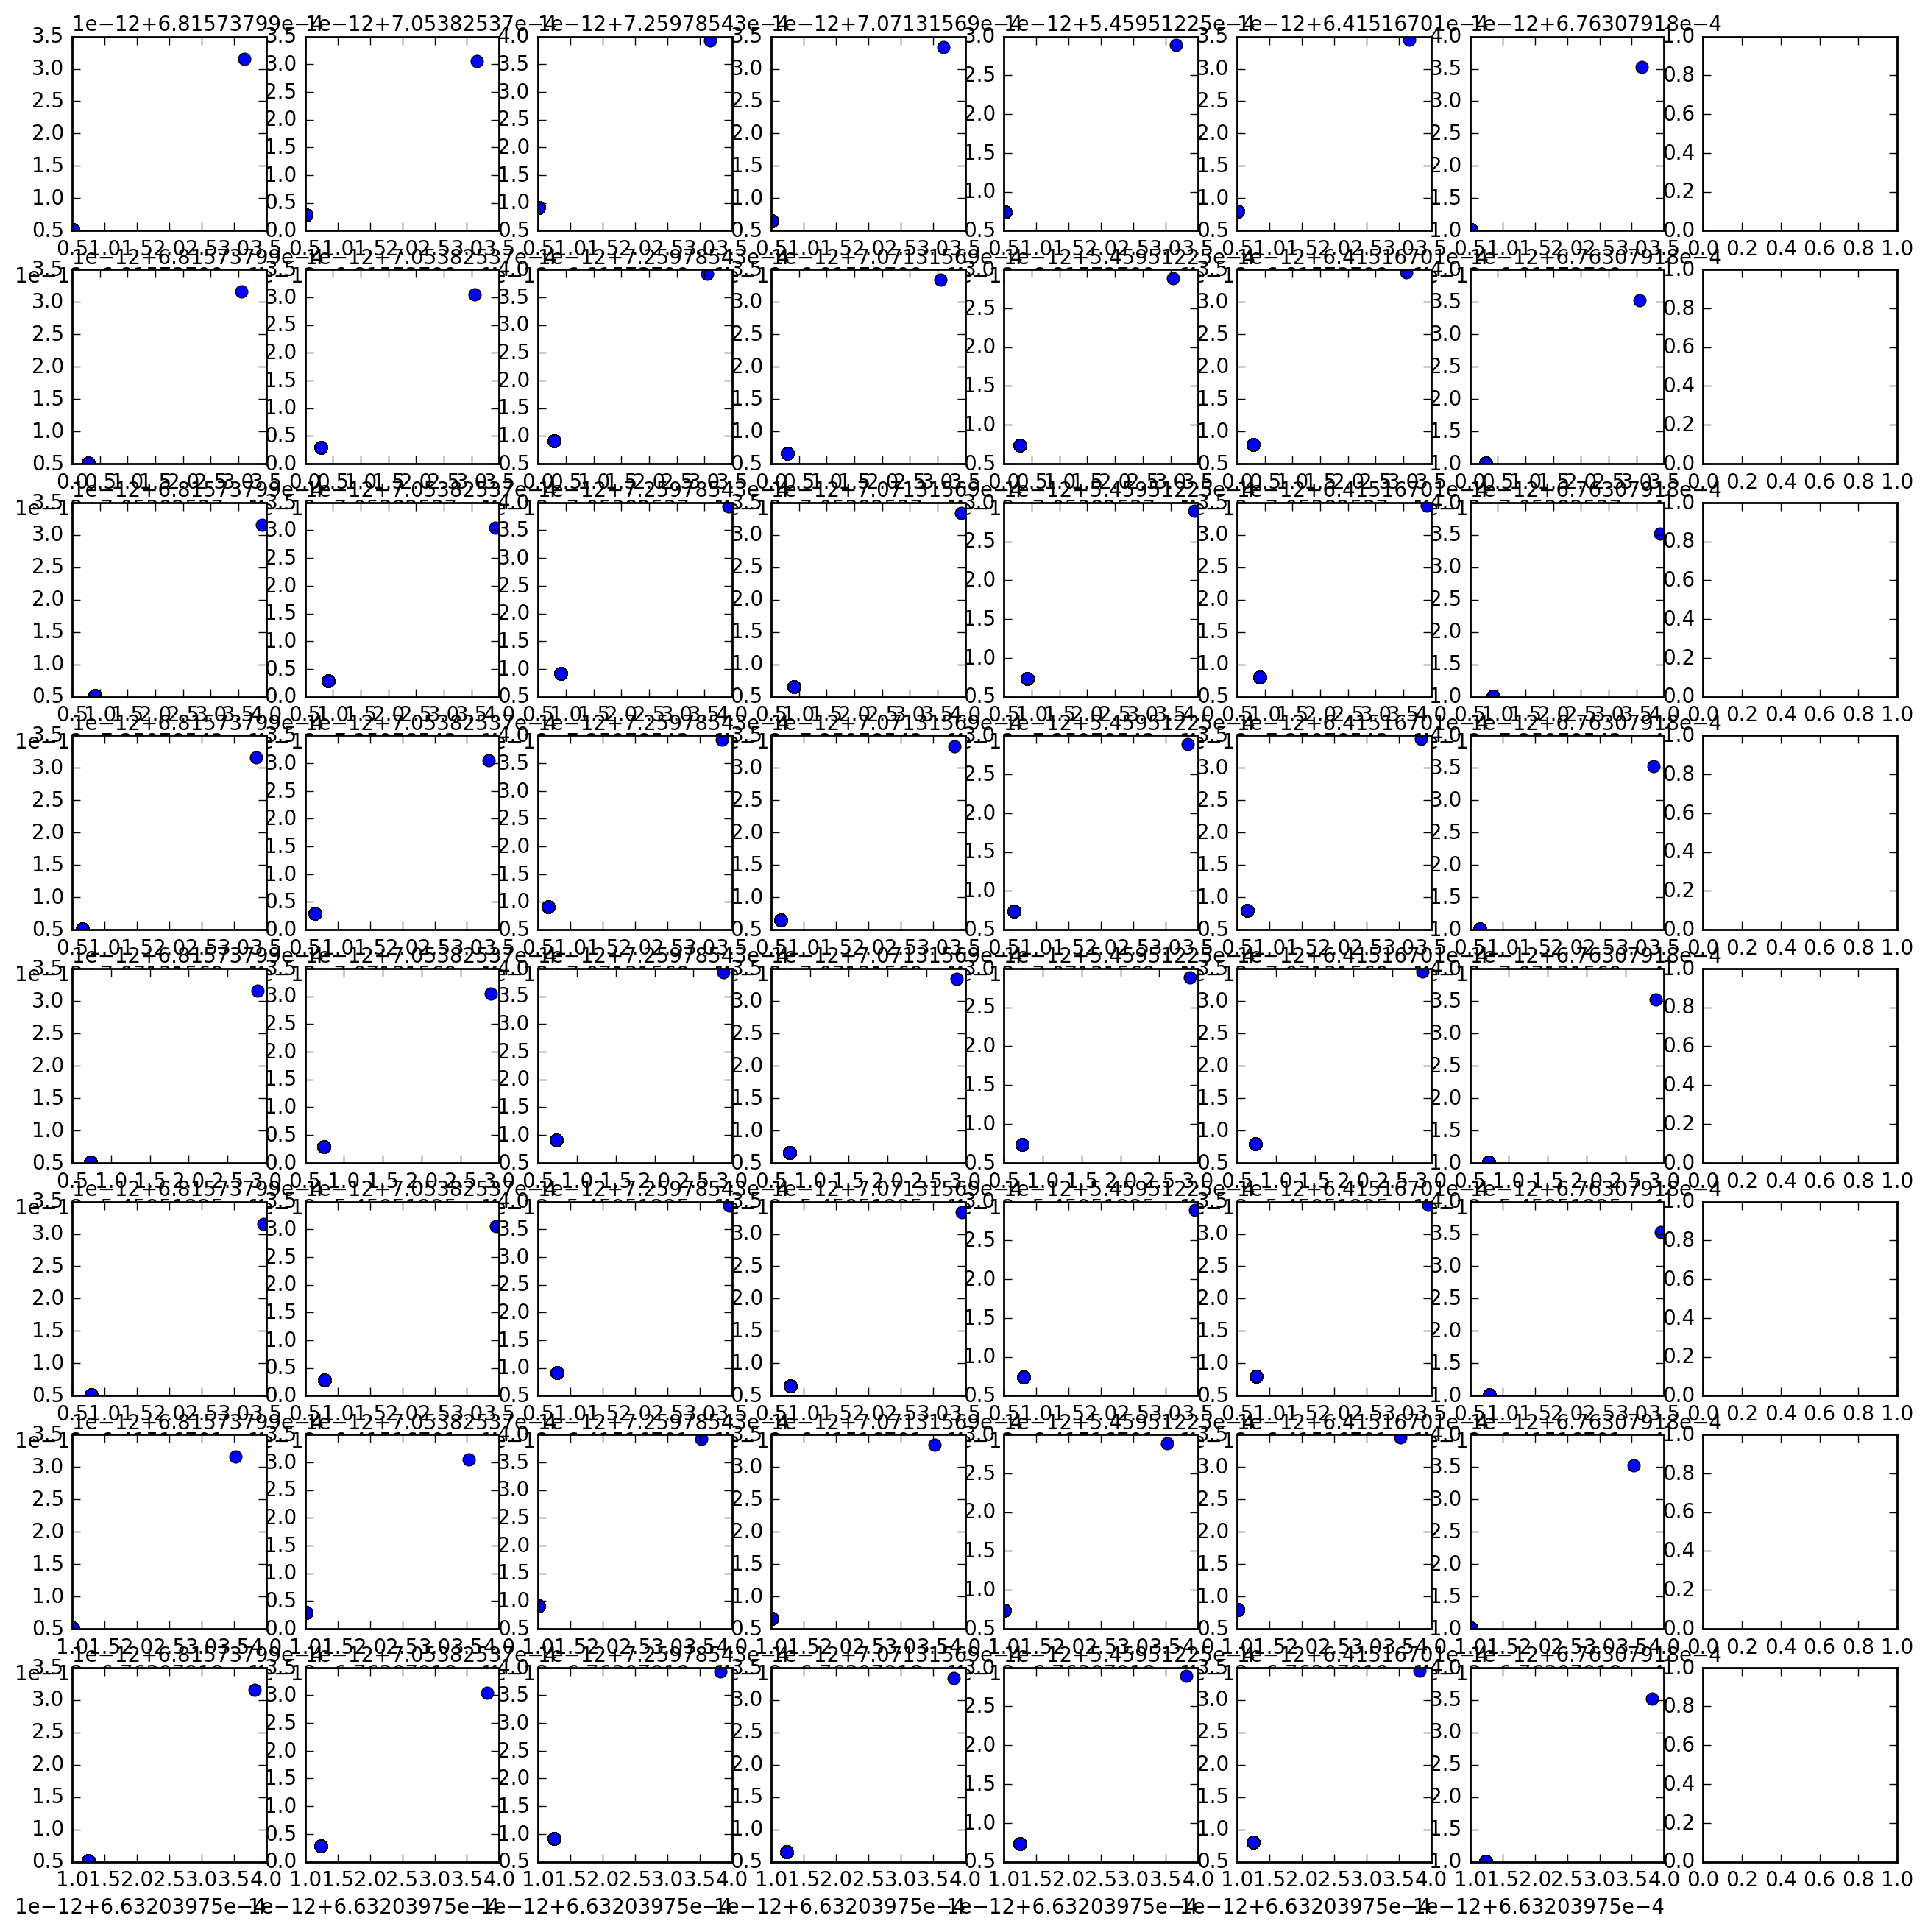

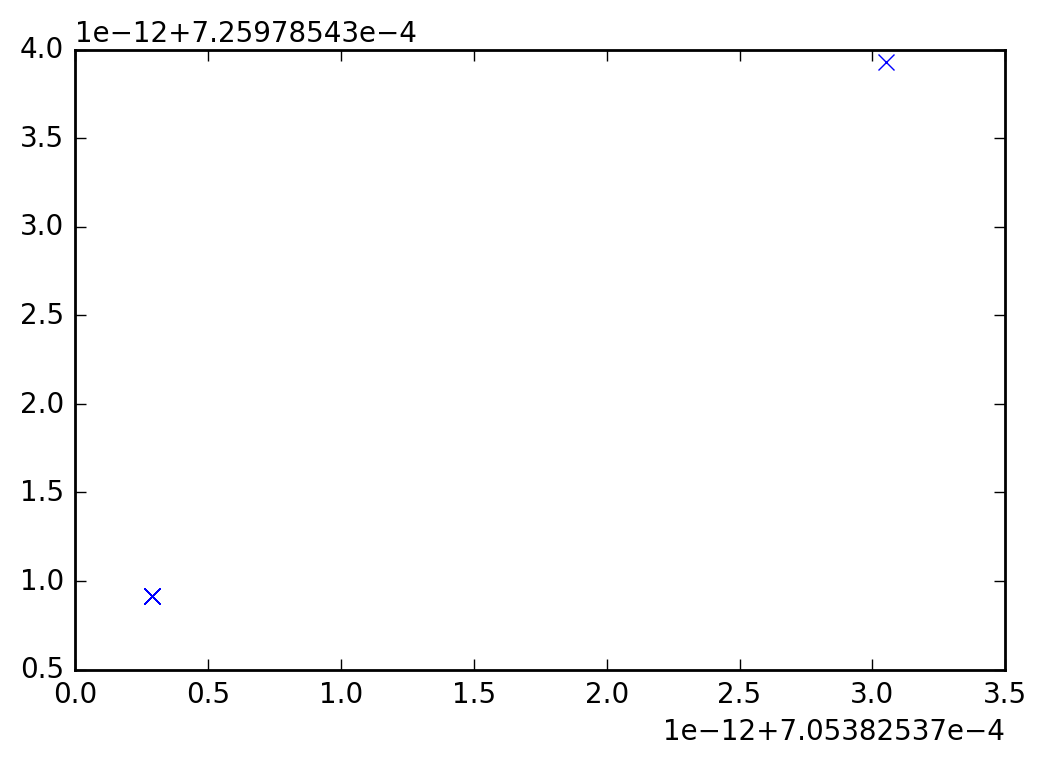

[ 0.00070538  0.00070538  0.00070538  0.00070538  0.00070538  0.00070538
  0.00070538  0.00070538  0.00070538  0.00070538  0.00070538  0.00070538
  0.00070538  0.00070538  0.00070538  0.00070538  0.00070538  0.00070538
  0.00070538  0.00070538  0.00070538  0.00070538  0.00070538  0.00070538
  0.00070538  0.00070538  0.00070538  0.00070538  0.00070538  0.00070538
  0.00070538  0.00070538  0.00070538  0.00070538  0.00070538  0.00070538
  0.00070538  0.00070538  0.00070538  0.00070538  0.00070538  0.00070538
  0.00070538  0.00070538  0.00070538  0.00070538  0.00070538  0.00070538
  0.00070538  0.00070538  0.00070538  0.00070538  0.00070538  0.00070538
  0.00070538  0.00070538  0.00070538  0.00070538  0.00070538  0.00070538
  0.00070538  0.00070538  0.00070538  0.00070538  0.00070538  0.00070538
  0.00070538  0.00070538  0.00070538  0.00070538  0.00070538  0.00070538
  0.00070538  0.00070538  0.00070538  0.00070538  0.00070538  0.00070538
  0.00070538  0.00070538  0.00070538  0.00070538  0

In [35]:
an,zn = forProp(a0,myNewWeights1)
print(np.shape(an[4][:,1]))

if (1):
    myFig, myAx = plt.subplots(8,8,figsize=(16,16))
    for cx in range(0,8):
        for cy in range(7):
            myAx[cx,cy].plot(an[3][:,cx].T,an[3][:,cy].T,'o')
plt.show()
plt.figure()
plt.plot(an[3][:,1],an[3][:,2],'x')
plt.show()
print(an[3][:,1])
            

In [20]:
# Break the text into a description and requirements section, if possible
myDescLoc = myText.find('Description')
if (myDescLoc == -1):
    #print('lowercase')
    myDescLoc = myText.find('description')
elif (myDescLoc == -1):
    print('Failed to find job description')
        
myReqLoc = myText.find('Requirements')
if (myReqLoc == -1):
    #print('lowercase')
    myReqLoc = myText.find('requirements')
elif (myReqLoc == -1):
    print('Failed to find job requirements')
    
myDesc = myText[myDescLoc:myReqLoc]
myReq = myText[myReqLoc:len(myText)]
#print(myText[myReq:len(myText)])

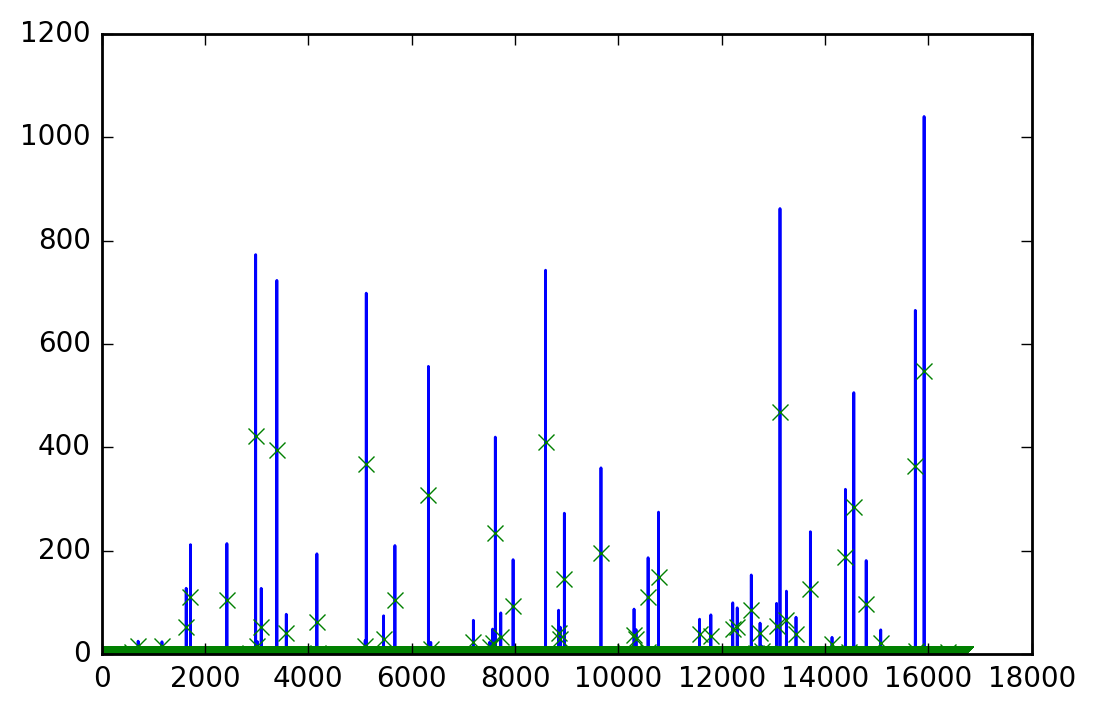

In [40]:
plt.plot(a0[:,100])
plt.plot(a0[:,50],'x')
plt.show()